<a href="https://colab.research.google.com/github/Eoli-an/influence-release/blob/master/CustomCNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))'''

"import tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))"

In [2]:
!git clone https://github.com/Eoli-an/influence-release customCNN
  

Cloning into 'customCNN'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 835 (delta 16), reused 22 (delta 0), pack-reused 797
Receiving objects: 100% (835/835), 153.03 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (608/608), done.
Checking out files: 100% (76/76), done.


In [0]:
import os
os.chdir('./customCNN')

In [4]:
!git pull

Already up to date.


# Training CNN and saving the influence of every training example(for the test image with test_idx)

handling imports

In [5]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import numpy as np
import IPython

import math
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse

sns.set(color_codes=True)

import tensorflow as tf

from influence.all_CNN_c import All_CNN_C
from scripts.load_mnist import load_small_mnist, load_mnist


Using TensorFlow backend.


loading the dataset

In [0]:
import h5py
path_to_matrices = "data/training_set.hdf5"
dataset = h5py.File(path_to_matrices, 'r')

In [0]:
matrices = np.array(dataset['matrices'])
labels = np.array(dataset['label_vectors'])

matrices = matrices[0:100,:]
labels = labels[0:100,:]



In [0]:
randomize = np.arange(len(matrices))
np.random.shuffle(randomize)
matrices = matrices[randomize]
labels = labels[randomize]

In [0]:
#from one hot to integer coding
i = 0
new_labels = []
for label in labels:
  index = np.argmax(label)
  new_labels.append(index)
  i+=1

labels = new_labels
labels = np.asarray(labels)

In [0]:
training_test_split = 0.8
index = int(training_test_split * len(matrices))

train_matrices = np.expand_dims(matrices[:index], axis=3)
train_labels = labels[:index]

validation_matrices = np.expand_dims(matrices[index + 1:], axis=3)
validation_labels = labels[index + 1:]

In [0]:
from tensorflow.contrib.learn.python.learn.datasets import base
from influence.dataset import DataSet


In [0]:
train = DataSet(train_matrices, train_labels)
validation = DataSet(validation_matrices, validation_labels)
test = DataSet(validation_matrices, validation_labels)

data_sets = base.Datasets(train=train, validation=validation, test=test)

defining the CNN

training the CNN

In [13]:
num_classes = 4
input_side = 128
input_channels = 1
input_dim = input_side * input_side * input_channels 
weight_decay = 0.001
batch_size = 1

initial_learning_rate = 0.0001 
decay_epochs = [10000, 20000]
hidden1_units = 8
hidden2_units = 8
hidden3_units = 8
conv_patch_size = 3
keep_probs = [1.0, 1.0]


model = All_CNN_C(
    input_side=input_side, 
    input_channels=input_channels,
    conv_patch_size=conv_patch_size,
    hidden1_units=hidden1_units, 
    hidden2_units=hidden2_units,
    hidden3_units=hidden3_units,
    weight_decay=weight_decay,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    damping=1e-2,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output', 
    log_dir='log',
    model_name='mnist_small_all_cnn_c')

W0817 09:13:17.769575 140261974615936 deprecation_wrapper.py:119] From /content/customCNN/influence/genericNeuralNet.py:83: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0817 09:13:17.779891 140261974615936 deprecation_wrapper.py:119] From /content/customCNN/influence/genericNeuralNet.py:107: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0817 09:13:17.780861 140261974615936 deprecation_wrapper.py:119] From /content/customCNN/influence/genericNeuralNet.py:108: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0817 09:13:19.006340 140261974615936 deprecation_wrapper.py:119] From /content/customCNN/influence/all_CNN_c.py:242: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 09:13:19.017426 140261974615936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_de

In [14]:
'''num_steps = 5000
model.train(
    num_steps=num_steps, 
    iter_to_switch_to_batch=10000,
    iter_to_switch_to_sgd=10000)
iter_to_load = num_steps - 1'''


'num_steps = 5000\nmodel.train(\n    num_steps=num_steps, \n    iter_to_switch_to_batch=10000,\n    iter_to_switch_to_sgd=10000)\niter_to_load = num_steps - 1'

calculating the influence

In [15]:
test_idx = 5

CNN_predicted_loss_diffs = model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(model.data_sets.train.labels)),
    force_refresh=True)

(19, 16384)
[5]
Norm of test gradient: 12.794741
Function value: -675.0255432128906
Split function value: -528.6010131835938, -146.42453
Predicted loss diff on train_idx 5: 0.04050368964672089
Function value: -734.6864013671875
Split function value: -588.2317504882812, -146.45471
Predicted loss diff on train_idx 5: 0.04051351547241211
Function value: -795.8733978271484
Split function value: -645.9938354492188, -149.87956
Predicted loss diff on train_idx 5: 0.041188913583755496
Function value: -855.7901000976562
Split function value: -705.8804321289062, -149.90967
Predicted loss diff on train_idx 5: 0.041199994087219236
Function value: -917.5445861816406
Split function value: -764.2791748046875, -153.26541
Predicted loss diff on train_idx 5: 0.04200344681739807
Function value: -977.7338409423828
Split function value: -824.4382934570312, -153.29555
Predicted loss diff on train_idx 5: 0.042015951871871945
Function value: -1040.0207214355469
Split function value: -883.462890625, -156.55783

saving the influence

In [0]:
np.savez(
    'output/CNN_results', 
    test_idx=test_idx,
    CNN_predicted_loss_diffs=CNN_predicted_loss_diffs
    
)

# **Loading influences and plotting the most influential pictures**

getting Xtrain of the Training Dataset

In [0]:
X_train = data_sets.train.x

loading the influences

In [0]:
f = np.load('output/CNN_results.npz')
    
test_idx = f['test_idx']
CNN_predicted_loss_diffs = f['CNN_predicted_loss_diffs']


Test Image:
Top 5 most influenatial matrices


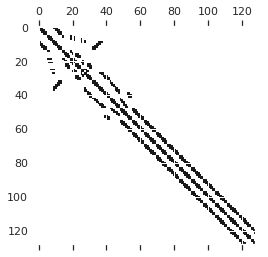

In [19]:
print("Test Image:")
plt.spy(np.reshape(X_train[test_idx, :], [128, 128]))
print("Top 5 most influenatial matrices")

In [0]:
#x_train = []
#for counter, train_idx in enumerate(np.argsort(CNN_predicted_loss_diffs)[-5:]):
#    x_train.append(X_train[train_idx, :])
    

x_train = []
for counter, train_idx in enumerate(np.argsort(CNN_predicted_loss_diffs)[0:5]):
  x_train.append(X_train[train_idx, :])

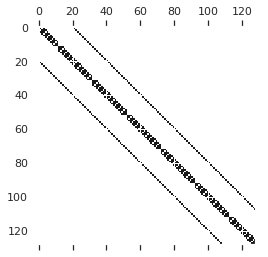

In [21]:
plt.spy(np.reshape(x_train[0], [128, 128]))

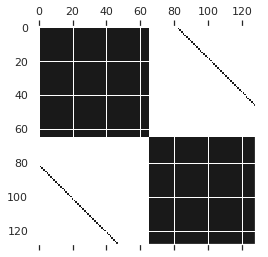

In [22]:
plt.spy(np.reshape(x_train[1], [128, 128]))

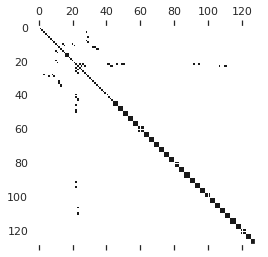

In [23]:
plt.spy(np.reshape(x_train[2], [128, 128]))

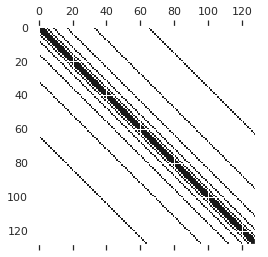

In [24]:
plt.spy(np.reshape(x_train[3], [128, 128]))

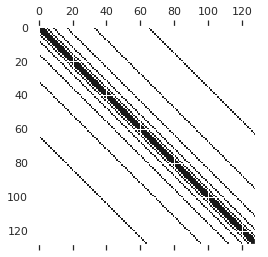

In [25]:
plt.spy(np.reshape(x_train[4], [128, 128]))